## Packages

In [1]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import pandas as pd
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netCDF4
# from netCDF4 import *

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from scipy import interpolate
from scipy.interpolate import griddata
import time
import glob
import dask

from scipy.fftpack import fft
from scipy.fftpack import ifft
import copy
import eofs.standard as Eof_st
from matplotlib.colors import ListedColormap
from matplotlib import ticker
import matplotlib.patches as mpatches

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cmocean

In [2]:
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')

client does not exist yet


In [3]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(project='NAML0001',walltime='12:00:00')
cluster.scale(40)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/con

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/Dango/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/Dango/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.42:34063,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/Dango/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
## data  dir-ty
Datadir = '/glade/scratch/kjmayer/DATA/CESM2-piControl/daily/'
z500cesm = xr.open_dataset(Datadir+'Z500v2_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc')
z500era = xr.open_dataset(Datadir+'Z500v2_ERA5_1974_2020.001.nc') 
MJOcesm = xr.open_dataset(Datadir+'MJO_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc')
MJOera = xr.open_dataset(Datadir+'Observed_MJO_BOMindex.nc')

## MJOera

In [309]:
timeMJO6 = MJOera.where(MJOera['BOM_phase']==6,drop=True)['time']
timeMJO7 = MJOera.where(MJOera['BOM_phase']==7,drop=True)['time']

time_offsets = [pd.Timedelta(days=5), pd.Timedelta(days=6),pd.Timedelta(days=7),pd.Timedelta(days=8),pd.Timedelta(days=9)]
concatenated_time_series06 = xr.concat([timeMJO6['time'] + offset for offset in time_offsets], dim='time')
concatenated_time_series07 = xr.concat([timeMJO7['time'] + offset for offset in time_offsets], dim='time')

concatall = xr.concat([concatenated_time_series06,concatenated_time_series07],dim='time')
ndjfm_mask = (concatall['time.month'] >= 11) | (concatall['time.month'] <= 3)
ndjfm_data = concatall.sel(time=ndjfm_mask)
concatall = np.unique(ndjfm_data)
DSm67_era = z500era.sel(time=np.unique(concatall),method='nearest')['Z500a'].mean('time')

timeMJO3 = MJOera.where(MJOera['BOM_phase']==3,drop=True)['time']
timeMJO4 = MJOera.where(MJOera['BOM_phase']==4,drop=True)['time']

time_offsets = [pd.Timedelta(days=5), pd.Timedelta(days=6),pd.Timedelta(days=7),pd.Timedelta(days=8),pd.Timedelta(days=9)]
concatenated_time_series03 = xr.concat([timeMJO3['time'] + offset for offset in time_offsets], dim='time')
concatenated_time_series04 = xr.concat([timeMJO4['time'] + offset for offset in time_offsets], dim='time')

concatall = xr.concat([concatenated_time_series03,concatenated_time_series04],dim='time')
ndjfm_mask = (concatall['time.month'] >= 11) | (concatall['time.month'] <= 3)
ndjfm_data = concatall.sel(time=ndjfm_mask)
concatall = np.unique(ndjfm_data)
DSm34_era = z500era.sel(time=np.unique(concatall),method='nearest')['Z500a'].mean('time')

## MJOcesm

In [310]:
timeMJO6 = MJOcesm.where(MJOcesm['RMMphase_CESM2']==6,drop=True)['time']
timeMJO7 = MJOcesm.where(MJOcesm['RMMphase_CESM2']==7,drop=True)['time']

time_offsets = [pd.Timedelta(days=5), pd.Timedelta(days=6),pd.Timedelta(days=7),pd.Timedelta(days=8),pd.Timedelta(days=9)]
concatenated_time_series06 = xr.concat([timeMJO6['time'] + offset for offset in time_offsets], dim='time')
concatenated_time_series07 = xr.concat([timeMJO7['time'] + offset for offset in time_offsets], dim='time')

concatall = xr.concat([concatenated_time_series06,concatenated_time_series07],dim='time')
ndjfm_mask = (concatall['time.month'] >= 11) | (concatall['time.month'] <= 3)
ndjfm_data = concatall.sel(time=ndjfm_mask)
concatall = np.unique(ndjfm_data)
print('taking mean')
DSm67_cesm = z500cesm.sel(time=np.unique(concatall),method='nearest')['Z500a'].mean('time')


timeMJO3 = MJOcesm.where(MJOcesm['RMMphase_CESM2']==3,drop=True)['time']
timeMJO4 = MJOcesm.where(MJOcesm['RMMphase_CESM2']==4,drop=True)['time']

time_offsets = [pd.Timedelta(days=5), pd.Timedelta(days=6),pd.Timedelta(days=7),pd.Timedelta(days=8),pd.Timedelta(days=9)]
concatenated_time_series03 = xr.concat([timeMJO3['time'] + offset for offset in time_offsets], dim='time')
concatenated_time_series04 = xr.concat([timeMJO4['time'] + offset for offset in time_offsets], dim='time')

concatall = xr.concat([concatenated_time_series03,concatenated_time_series04],dim='time')
ndjfm_mask = (concatall['time.month'] >= 11) | (concatall['time.month'] <= 3)
ndjfm_data = concatall.sel(time=ndjfm_mask)
concatall = np.unique(ndjfm_data)
print('taking mean')
DSm34_cesm = z500cesm.sel(time=np.unique(concatall),method='nearest')['Z500a'].mean('time')

taking mean
taking mean


In [311]:
###########
#change your parameters
clevs=np.arange(-140,145,5)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn =int(np.floor(newcolors.shape[0]/2))
newcolors[nnn]=newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1]=newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1]=newcolors[nnn-1]/newcolors[nnn-1]
newcolors[nnn-2]=newcolors[nnn-2]/newcolors[nnn-2]
cmapzzz = ListedColormap(newcolors)

clevs_cont = np.concatenate([clevs[0:nnn],clevs[nnn+1:]])
clevs_cont2 = np.array([clevs[nnn-1],clevs[nnn+1]])
############ 

/glade/scratch/wchapman/ipykernel_128343/1945198924.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))


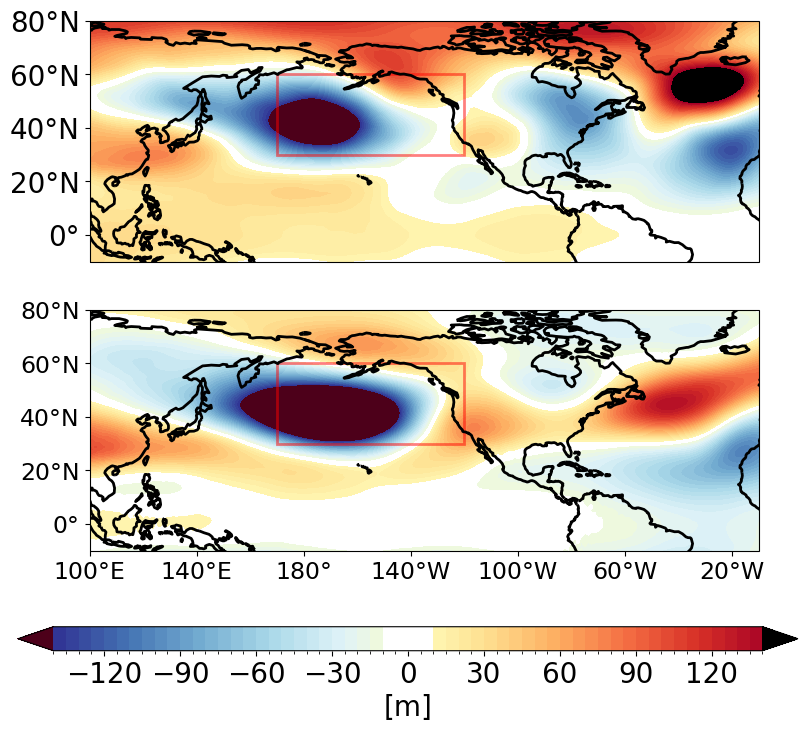

In [312]:
plotter = DSm67_era.squeeze()
cmap = cmapzzz
lon = DSm67['lon']
lat = DSm67['lat']
norm = mpl.colors.BoundaryNorm(clevs, cmap.N)



###
# Define the coordinates of the box
min_lon = 170.0  # Minimum longitude
max_lon = 240.0  # Maximum longitude
min_lat = 30.0   # Minimum latitude
max_lat = 60.0   # Maximum latitude

# Create a Rectangle patch
box1 = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                         linewidth=2, edgecolor='r', facecolor='none',
                         transform=ccrs.PlateCarree(),alpha=0.5)
# Create a Rectangle patch
box2 = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                         linewidth=2, edgecolor='r', facecolor='none',
                         transform=ccrs.PlateCarree(),alpha=0.5)

# Add the box to the plot

## +++plotting functionality 
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(13,10),sharex=True,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# ax1 = ax.ravel()

# fig = plt.figure(figsize=(30, 10))
proj = ccrs.PlateCarree(central_longitude=180)
# ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('110m',linewidth=2)
cmap.set_over('k')
cmap.set_under([0.3, 0.00, 0.1, 1.0])
bb=ax1.contourf(lon-180,lat,plotter,levels=clevs,cmap=cmap,transform=proj,extend='both')
# plt.contour(lon-180,lat,plotCont,levels=np.arange(100,500,50),colors='k',transform=proj)
   
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                scale='10m',
                facecolor='none')

ax1.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter(number_format='.0f')
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=20) 
ax1.set_extent([-10, 100, -10, 80], crs=ccrs.PlateCarree())
ax1.add_patch(box1)


plotter = DSm67_cesm.squeeze()
cmap = cmapzzz
lon = DSm67['lon']
lat = DSm67['lat']
norm = mpl.colors.BoundaryNorm(clevs, cmap.N)

#####
## +++plotting functionality 

# fig = plt.figure(figsize=(30, 10))
proj = ccrs.PlateCarree(central_longitude=180)
# ax1 = plt.subplot(1, 1, 1, projection=proj)
ax2.coastlines('110m',linewidth=2)
cmap.set_over('k')
cmap.set_under([0.3, 0.00, 0.1, 1.0])
bb=ax2.contourf(lon-180,lat,plotter*9.81,levels=clevs,cmap=cmap,transform=proj,extend='both')
# plt.contour(lon-180,lat,plotCont,levels=np.arange(100,500,50),colors='k',transform=proj)
   
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                scale='10m',
                facecolor='none')

ax2.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter(number_format='.0f')
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(labelsize=17) 

ax2.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(labelsize=17)   
ax2.add_patch(box2)

ax2.set_extent([100, 350, -10, 80], crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.35)

## ---plotting functionality 
ax2 = fig.add_axes([0.20, 0.25, 0.6, 0.024])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevs, boundaries=clevs,orientation='horizontal')
ax2.set_xlabel('[m]', size=20)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
## ---plotting functionality 
plt.show()


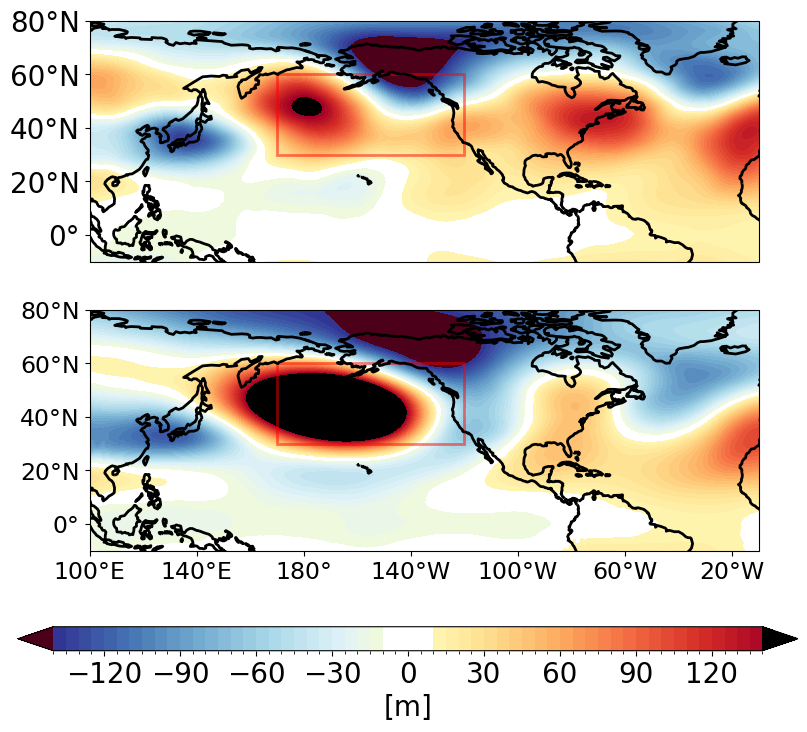

In [313]:
plotter = DSm34_era.squeeze()
cmap = cmapzzz
lon = DSm67['lon']
lat = DSm67['lat']
norm = mpl.colors.BoundaryNorm(clevs, cmap.N)



###
# Define the coordinates of the box
min_lon = 170.0  # Minimum longitude
max_lon = 240.0  # Maximum longitude
min_lat = 30.0   # Minimum latitude
max_lat = 60.0   # Maximum latitude

# Create a Rectangle patch
box1 = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                         linewidth=2, edgecolor='r', facecolor='none',
                         transform=ccrs.PlateCarree(),alpha=0.5)
# Create a Rectangle patch
box2 = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                         linewidth=2, edgecolor='r', facecolor='none',
                         transform=ccrs.PlateCarree(),alpha=0.5)

# Add the box to the plot

## +++plotting functionality 
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(13,10),sharex=True,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# ax1 = ax.ravel()

# fig = plt.figure(figsize=(30, 10))
proj = ccrs.PlateCarree(central_longitude=180)
# ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('110m',linewidth=2)
cmap.set_over('k')
cmap.set_under([0.3, 0.00, 0.1, 1.0])
bb=ax1.contourf(lon-180,lat,plotter,levels=clevs,cmap=cmap,transform=proj,extend='both')
# plt.contour(lon-180,lat,plotCont,levels=np.arange(100,500,50),colors='k',transform=proj)
   
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                scale='10m',
                facecolor='none')

ax1.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter(number_format='.0f')
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=20) 
ax1.set_extent([-10, 100, -10, 80], crs=ccrs.PlateCarree())
ax1.add_patch(box1)


plotter = DSm34_cesm.squeeze()
cmap = cmapzzz
lon = DSm67['lon']
lat = DSm67['lat']
norm = mpl.colors.BoundaryNorm(clevs, cmap.N)

#####
## +++plotting functionality 

# fig = plt.figure(figsize=(30, 10))
proj = ccrs.PlateCarree(central_longitude=180)
# ax1 = plt.subplot(1, 1, 1, projection=proj)
ax2.coastlines('110m',linewidth=2)
cmap.set_over('k')
cmap.set_under([0.3, 0.00, 0.1, 1.0])
bb=ax2.contourf(lon-180,lat,plotter*9.81,levels=clevs,cmap=cmap,transform=proj,extend='both')
# plt.contour(lon-180,lat,plotCont,levels=np.arange(100,500,50),colors='k',transform=proj)
   
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                scale='10m',
                facecolor='none')

ax2.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter(number_format='.0f')
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(labelsize=17) 

ax2.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(labelsize=17)   
ax2.add_patch(box2)

ax2.set_extent([100, 350, -10, 80], crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.35)

## ---plotting functionality 
ax2 = fig.add_axes([0.20, 0.25, 0.6, 0.024])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevs, boundaries=clevs,orientation='horizontal')
ax2.set_xlabel('[m]', size=20)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
## ---plotting functionality 
plt.show()


## Frequency

In [4]:
timeMJO6 = MJOera.where(MJOera['BOM_phase']==6,drop=True)['time']
timeMJO7 = MJOera.where(MJOera['BOM_phase']==7,drop=True)['time']

time_offsets = [pd.Timedelta(days=7), pd.Timedelta(days=8),pd.Timedelta(days=9),pd.Timedelta(days=10),pd.Timedelta(days=11),pd.Timedelta(days=12),pd.Timedelta(days=13),pd.Timedelta(days=14)]
concatenated_time_series06 = xr.concat([timeMJO6['time'] + offset for offset in time_offsets], dim='time')
concatenated_time_series07 = xr.concat([timeMJO7['time'] + offset for offset in time_offsets], dim='time')

concatall = xr.concat([concatenated_time_series06,concatenated_time_series07],dim='time')
ndjfm_mask = (concatall['time.month'] >= 11) | (concatall['time.month'] <= 3)
ndjfm_data = concatall.sel(time=ndjfm_mask)
concatall = np.unique(ndjfm_data)
DSm67_era = ((z500era.sel(time=np.unique(concatall),method='nearest')['Z500a']<0).sum('time'))/len(np.unique(concatall))

timeMJO3 = MJOera.where(MJOera['BOM_phase']==2,drop=True)['time']
timeMJO4 = MJOera.where(MJOera['BOM_phase']==3,drop=True)['time']

time_offsets = [pd.Timedelta(days=7), pd.Timedelta(days=8),pd.Timedelta(days=9),pd.Timedelta(days=10),pd.Timedelta(days=11),pd.Timedelta(days=12),pd.Timedelta(days=13),pd.Timedelta(days=14)]
concatenated_time_series03 = xr.concat([timeMJO3['time'] + offset for offset in time_offsets], dim='time')
concatenated_time_series04 = xr.concat([timeMJO4['time'] + offset for offset in time_offsets], dim='time')

concatall = xr.concat([concatenated_time_series03,concatenated_time_series04],dim='time')
ndjfm_mask = (concatall['time.month'] >= 11) | (concatall['time.month'] <= 3)
ndjfm_data = concatall.sel(time=ndjfm_mask)
concatall = np.unique(ndjfm_data)
DSm34_era = ((z500era.sel(time=np.unique(concatall),method='nearest')['Z500a']>0).sum('time'))/len(np.unique(concatall))


###########
timeMJO6 = MJOcesm.where(MJOcesm['RMMphase_CESM2']==6,drop=True)['time']
timeMJO7 = MJOcesm.where(MJOcesm['RMMphase_CESM2']==7,drop=True)['time']

time_offsets = [pd.Timedelta(days=7), pd.Timedelta(days=8),pd.Timedelta(days=9),pd.Timedelta(days=10),pd.Timedelta(days=11),pd.Timedelta(days=12),pd.Timedelta(days=13),pd.Timedelta(days=14)]
concatenated_time_series06 = xr.concat([timeMJO6['time'] + offset for offset in time_offsets], dim='time')
concatenated_time_series07 = xr.concat([timeMJO7['time'] + offset for offset in time_offsets], dim='time')

concatall = xr.concat([concatenated_time_series06,concatenated_time_series07],dim='time')
ndjfm_mask = (concatall['time.month'] >= 11) | (concatall['time.month'] <= 3)
ndjfm_data = concatall.sel(time=ndjfm_mask)
concatall = np.unique(ndjfm_data)
print('taking mean')
DSm67_cesm = ((z500cesm.sel(time=np.unique(concatall),method='nearest')['Z500a']<0).sum('time'))/len(np.unique(concatall))


timeMJO3 = MJOcesm.where(MJOcesm['RMMphase_CESM2']==2,drop=True)['time']
timeMJO4 = MJOcesm.where(MJOcesm['RMMphase_CESM2']==3,drop=True)['time']

time_offsets = [pd.Timedelta(days=7), pd.Timedelta(days=8),pd.Timedelta(days=9),pd.Timedelta(days=10),pd.Timedelta(days=11),pd.Timedelta(days=12),pd.Timedelta(days=13),pd.Timedelta(days=14)]
concatenated_time_series03 = xr.concat([timeMJO3['time'] + offset for offset in time_offsets], dim='time')
concatenated_time_series04 = xr.concat([timeMJO4['time'] + offset for offset in time_offsets], dim='time')

concatall = xr.concat([concatenated_time_series03,concatenated_time_series04],dim='time')
ndjfm_mask = (concatall['time.month'] >= 11) | (concatall['time.month'] <= 3)
ndjfm_data = concatall.sel(time=ndjfm_mask)
concatall = np.unique(ndjfm_data)
print('taking mean')
DSm34_cesm = ((z500cesm.sel(time=np.unique(concatall),method='nearest')['Z500a']>0).sum('time'))/len(np.unique(concatall))


taking mean
taking mean


In [5]:
###########
#change your parameters
clevs=np.arange(0.4,.6,.005)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn =int(np.floor(newcolors.shape[0]/2))
newcolors[nnn]=newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1]=newcolors[nnn+1]/newcolors[nnn+1]
# newcolors[nnn-1]=newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

clevs_cont = np.concatenate([clevs[0:nnn],clevs[nnn+1:]])
clevs_cont2 = np.array([clevs[nnn-1],clevs[nnn+1]])
############ 

/glade/scratch/wchapman/ipykernel_187348/742994054.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))


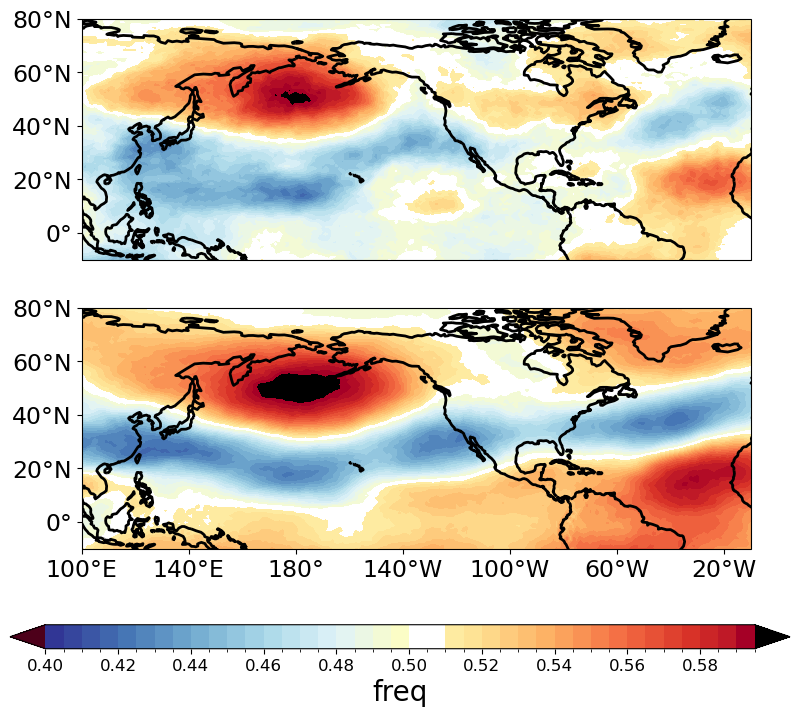

In [9]:
plotter = DSm67_era.squeeze()
cmap = cmapzzz
lon = DSm34_era['lon']
lat = DSm34_era['lat']
norm = mpl.colors.BoundaryNorm(clevs, cmap.N)



###
# Define the coordinates of the box
min_lon = 170.0  # Minimum longitude
max_lon = 240.0  # Maximum longitude
min_lat = 30.0   # Minimum latitude
max_lat = 60.0   # Maximum latitude

# Create a Rectangle patch
box1 = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                         linewidth=2, edgecolor='r', facecolor='none',
                         transform=ccrs.PlateCarree(),alpha=0.5)
# Create a Rectangle patch
box2 = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                         linewidth=2, edgecolor='r', facecolor='none',
                         transform=ccrs.PlateCarree(),alpha=0.5)

# Add the box to the plot

## +++plotting functionality 
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(13,10),sharex=True,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# ax1 = ax.ravel()

# fig = plt.figure(figsize=(30, 10))
proj = ccrs.PlateCarree(central_longitude=180)
# ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('110m',linewidth=2)
cmap.set_over('k')
cmap.set_under([0.3, 0.00, 0.1, 1.0])
bb=ax1.contourf(lon-180,lat,plotter,levels=clevs,cmap=cmap,transform=proj,extend='both')
# plt.contour(lon-180,lat,plotCont,levels=np.arange(100,500,50),colors='k',transform=proj)
   
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                scale='10m',
                facecolor='none')

ax1.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter(number_format='.0f')
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=17) 
ax1.set_extent([-10, 100, -10, 80], crs=ccrs.PlateCarree())
# ax1.add_patch(box1)


plotter = DSm67_cesm.squeeze()
cmap = cmapzzz
lon = DSm34_era['lon']
lat = DSm34_era['lat']
norm = mpl.colors.BoundaryNorm(clevs, cmap.N)

#####
## +++plotting functionality 

# fig = plt.figure(figsize=(30, 10))
proj = ccrs.PlateCarree(central_longitude=180)
# ax1 = plt.subplot(1, 1, 1, projection=proj)
ax2.coastlines('110m',linewidth=2)
cmap.set_over('k')
cmap.set_under([0.3, 0.00, 0.1, 1.0])
bb=ax2.contourf(lon-180,lat,plotter,levels=clevs,cmap=cmap,transform=proj,extend='both')
# plt.contour(lon-180,lat,plotCont,levels=np.arange(100,500,50),colors='k',transform=proj)
   
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                scale='10m',
                facecolor='none')

ax2.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter(number_format='.0f')
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(labelsize=17) 

ax2.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(labelsize=17)   
# ax2.add_patch(box2)

ax2.set_extent([100, 350, -10, 80], crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.35)

## ---plotting functionality 
ax2 = fig.add_axes([0.20, 0.25, 0.6, 0.024])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevs, boundaries=clevs,orientation='horizontal')
ax2.set_xlabel('freq', size=20)
cb.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
## ---plotting functionality 
plt.show()


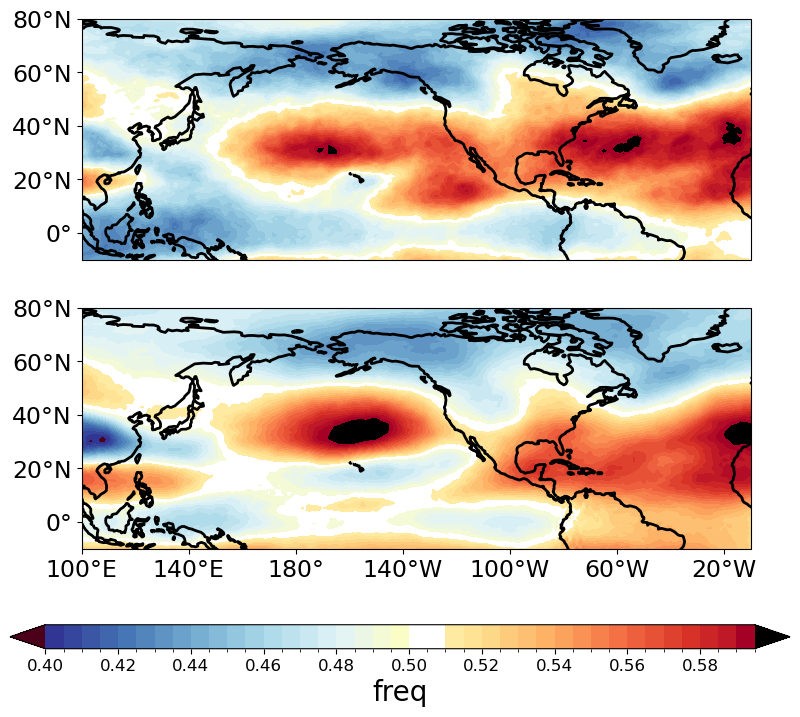

In [10]:
plotter = DSm34_era.squeeze()
cmap = cmapzzz
lon = DSm34_era['lon']
lat = DSm34_era['lat']
norm = mpl.colors.BoundaryNorm(clevs, cmap.N)

###
# Define the coordinates of the box
min_lon = 170.0  # Minimum longitude
max_lon = 240.0  # Maximum longitude
min_lat = 30.0   # Minimum latitude
max_lat = 60.0   # Maximum latitude

# Create a Rectangle patch
box1 = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                         linewidth=2, edgecolor='r', facecolor='none',
                         transform=ccrs.PlateCarree(),alpha=0.5)
# Create a Rectangle patch
box2 = mpatches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                         linewidth=2, edgecolor='r', facecolor='none',
                         transform=ccrs.PlateCarree(),alpha=0.5)

# Add the box to the plot

## +++plotting functionality 
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(13,10),sharex=True,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# ax1 = ax.ravel()

# fig = plt.figure(figsize=(30, 10))
proj = ccrs.PlateCarree(central_longitude=180)
# ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('110m',linewidth=2)
cmap.set_over('k')
cmap.set_under([0.3, 0.00, 0.1, 1.0])
bb=ax1.contourf(lon-180,lat,plotter,levels=clevs,cmap=cmap,transform=proj,extend='both')
# plt.contour(lon-180,lat,plotCont,levels=np.arange(100,500,50),colors='k',transform=proj)
   
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                scale='10m',
                facecolor='none')

ax1.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter(number_format='.0f')
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=17) 
ax1.set_extent([-10, 100, -10, 80], crs=ccrs.PlateCarree())
# ax1.add_patch(box1)


plotter = DSm34_cesm.squeeze()
cmap = cmapzzz
lon = DSm34_era['lon']
lat = DSm34_era['lat']
norm = mpl.colors.BoundaryNorm(clevs, cmap.N)

#####
## +++plotting functionality 

# fig = plt.figure(figsize=(30, 10))
proj = ccrs.PlateCarree(central_longitude=180)
# ax1 = plt.subplot(1, 1, 1, projection=proj)
ax2.coastlines('110m',linewidth=2)
cmap.set_over('k')
cmap.set_under([0.3, 0.00, 0.1, 1.0])
bb=ax2.contourf(lon-180,lat,plotter,levels=clevs,cmap=cmap,transform=proj,extend='both')
# plt.contour(lon-180,lat,plotCont,levels=np.arange(100,500,50),colors='k',transform=proj)
   
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                scale='10m',
                facecolor='none')

ax2.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter(number_format='.0f')
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(labelsize=17) 

ax2.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(labelsize=17)   
# ax2.add_patch(box2)

ax2.set_extent([100, 350, -10, 80], crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.35)

## ---plotting functionality 
ax2 = fig.add_axes([0.20, 0.25, 0.6, 0.024])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevs, boundaries=clevs,orientation='horizontal')
ax2.set_xlabel('freq', size=20)
cb.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
## ---plotting functionality 
plt.show()
